# Półmaraton Wrocław 2023

## 1. Import bibliotek

In [1]:
from dotenv import load_dotenv
from io import BytesIO
from pycaret.regression import *
import boto3
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm
from itables import show


# Dane dostępu z załadowane z pliku.env
load_dotenv()

True

## 2. Komunikacja z Digital Ocean

In [2]:
# Klient s3
s3 = boto3.client('s3')
# Nazwa kontenera w Digital Ocean
BUCKET_NAME='maraton'

In [7]:
# Wysłanie plików do kontenera
s3.upload_file(
    'data/halfmarathon_wroclaw_2023__final.csv',
    Bucket = BUCKET_NAME,
    Key = 'data/halfmarathon_wroclaw_2023__final.csv'
)
s3.upload_file(
    'data/halfmarathon_wroclaw_2024__final.csv',
    Bucket = BUCKET_NAME,
    Key = 'data/halfmarathon_wroclaw_2024__final.csv'
)

## 3. Funkcje

In [4]:
# Zmiana czasu uzyskanego przez zawodników z formatu h:m:s, na sekundy
def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

In [5]:
def download_to_df(file):
    obj = s3.get_object(Bucket=BUCKET_NAME, Key=file)
    return pd.read_csv(BytesIO(obj['Body'].read()), sep=";")


In [6]:
def seconds_to_time(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

## 4. Dataframe

In [5]:
# Wczytanie danych z plików do DataFrame
files = [
    'data/halfmarathon_wroclaw_2023__final.csv',
    'data/halfmarathon_wroclaw_2024__final.csv'
]

df = pd.concat(
    [download_to_df(file) for file in files],
    ignore_index=True
)
show(df)

NameError: name 'download_to_df' is not defined

In [8]:
# Sprawdź duplikaty w df
df.duplicated().sum()


0

In [9]:
# Zmiana czasu uzyskanego przez zawodników z formatu h:m:s, na sekundy
# Przeszukaj nazwy kolumn i zastosuj funkcję do tych, które zawierają słowo "Czas"
for kolumna in df.columns:
    if 'Czas' in kolumna:
        df[kolumna] = df[kolumna].apply(convert_time_to_seconds)

df.head()

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,2.926667,2687.0,1.0,3.106667,3703.0,1.0,3.386667,0.031400,3899.0,3.080509
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,2.983333,2726.0,2.0,3.143333,3788.0,2.0,3.540000,0.038000,3983.0,3.146875
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,3.123333,2854.0,3.0,3.236667,3909.0,3.0,3.516667,0.024067,4104.0,3.242475
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,3.196667,2929.0,5.0,3.330000,4014.0,4.0,3.616667,0.025467,4216.0,3.330963
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,3.276667,2971.0,7.0,3.386667,4047.0,5.0,3.586667,0.023000,4227.0,3.339654


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21957 entries, 0 to 21956
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Miejsce                    18450 non-null  float64
 1   Numer startowy             21957 non-null  int64  
 2   Imię                       21957 non-null  object 
 3   Nazwisko                   21957 non-null  object 
 4   Miasto                     17774 non-null  object 
 5   Kraj                       18450 non-null  object 
 6   Drużyna                    8402 non-null   object 
 7   Płeć                       21946 non-null  object 
 8   Płeć Miejsce               18450 non-null  float64
 9   Kategoria wiekowa          21926 non-null  object 
 10  Kategoria wiekowa Miejsce  18430 non-null  float64
 11  Rocznik                    21472 non-null  float64
 12  5 km Czas                  18411 non-null  float64
 13  5 km Miejsce Open          18411 non-null  flo

### Brakujące wartości

In [11]:
# Wyswietl wszystkie wiersze, gdzie 5 km Czas i Czas jest NaN
df[df['5 km Czas'].isna() & df['Czas'].isna()]

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
8150,NaN,7890,PATRYCJA,ADAMISZYN,NaN,NaN,NaN,K,NaN,K20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8151,NaN,8199,JACOB,ADAMS,NaN,NaN,NaN,M,NaN,M20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8152,NaN,2392,MARIUSZ,ADAMSKI,NaN,NaN,Zefka Runners,M,NaN,M30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8153,NaN,6105,MARCIN,ADAMSKI,NaN,NaN,NaN,M,NaN,M40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8154,NaN,6851,ADAM,ADAMSKI,NaN,NaN,NaN,M,NaN,M60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21952,NaN,6445,ANNA,ŻUROWSKA,NaN,NaN,NaN,K,NaN,K40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21953,NaN,23495,JUSTYNA,ŻYGADŁO,NaN,NaN,NaN,K,NaN,K20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21954,NaN,9323,DAWID,ŻYTKOWSKI,NaN,NaN,NaN,M,NaN,M20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21955,NaN,27386,DOMINIKA,ĆWIERTNIA,NaN,NaN,NaN,K,NaN,K30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Usuń wiersze, gdzie 5 km Czas i Czas jest NaN
df = df[~df['5 km Czas'].isna() & ~df['Czas'].isna()]

In [13]:
# Wyświetl kolumny z brakującymi danymi
braki = df.isna().sum().reset_index(name='Ilość').nlargest(27, 'Ilość')
braki.columns = ['Kolumna', 'Ilość']
braki['Procent (%)'] = (braki['Ilość'] / len(df) * 100).round(2)
braki.style.bar(
    subset='Procent (%)',
    color='blue',
    align='left',
    vmin=0,
    vmax=100
).hide(axis='index').format(precision=2)

Kolumna,Ilość,Procent (%)
Drużyna,11281,61.27
Miasto,673,3.66
Rocznik,484,2.63
Tempo Stabilność,34,0.18
15 km Tempo,29,0.16
20 km Tempo,22,0.12
Kategoria wiekowa,18,0.10
Kategoria wiekowa Miejsce,18,0.10
10 km Miejsce Open,16,0.09
15 km Miejsce Open,16,0.09


### Usuwamy brakujące wartości

In [14]:
# parametr thresh pozwala określić minimalną liczbę nie-NaN wartości, 
# które muszą być w wierszu(axis=0)/kolumnie(axis=1)
df = df.dropna(thresh=(0.60*len(df)),axis=1)

# w tym przypadku kolumna Drużyna jest, ponieważ ma wiecej niż 60% brakujących wartości

### Wartości odstające

In [15]:
Q1 = df["Czas"].quantile(0.25)
Q3 = df["Czas"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[~((df["Czas"] < lower_bound) | (df["Czas"] > upper_bound))]

### Ustalamy wiek zawodników

In [16]:
# Wypełnij brakujące wartości w kolumnie Płeć
df['Płeć'] = df['Płeć'].fillna(df['Płeć'].mode()[0])

In [17]:
# Oblicz wiek zawodników
df['Wiek'] = 2024 - df['Rocznik']
# Zamień wartości w kolumnie Płeć na 0 i 1
df['Płeć'] = df['Płeć'].map({'M': 0, 'K': 1})

In [18]:
# Wypełnij brakujące wartości w kolumnie Wiek
df['Wiek'] = df['Wiek'].fillna(df['Wiek'].mean())

In [19]:
# Sortuje 5 km Tempo rosnaco
df = df.sort_values(by='5 km Tempo', ascending=True)
# Wykonuje forward fill dla 5 km Tempo
df['5 km Tempo'] = df['5 km Tempo'].fillna(method='ffill')
# Wykonuje interpolację dla 5 km Czas
df['5 km Czas'] = df['5 km Czas'].interpolate(method='linear')

In [20]:
# Sortuje df po Tempo
df = df.sort_values(by='Tempo', ascending=True)
# Wykonuje forward fill dla Tempo
df['Tempo'] = df['Tempo'].fillna(method='ffill')
# Wykonuje interpolation dla Czas
df['Czas'] = df['Czas'].interpolate(method='linear')

In [21]:
df.head()

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Płeć,Płeć Miejsce,Kategoria wiekowa,Kategoria wiekowa Miejsce,...,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Wiek
8953,4.0,591,DARIUSZ,BORATYŃSKI,WROCŁAW,POL,0,4.0,M20,4.0,...,2868.0,4.0,3.293333,3940.0,4.0,3.573333,0.028667,4184.0,3.305681,27.0
8954,5.0,521,SZYMON,DOROŻYŃSKI,LUBON,POL,0,5.0,M30,1.0,...,2889.0,5.0,3.453333,3965.0,5.0,3.586667,0.039800,4205.0,3.322272,32.0
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,0,4.0,M30,3.0,...,2929.0,5.0,3.330000,4014.0,4.0,3.616667,0.025467,4216.0,3.330963,36.0
8955,6.0,342,SZYMON,GUMKOWSKI,GDAŃSK,POL,0,6.0,M20,5.0,...,2974.0,6.0,3.363333,3992.0,6.0,3.393333,0.007200,4218.0,3.332543,25.0
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,0,5.0,M20,2.0,...,2971.0,7.0,3.386667,4047.0,5.0,3.586667,0.023000,4227.0,3.339654,29.0


In [95]:
df['5 km Czas'].describe()

count    18185.000000
mean      1668.717404
std        238.390897
min          0.000000
25%       1502.000000
50%       1659.000000
75%       1830.000000
max       3825.000000
Name: 5 km Czas, dtype: float64

In [96]:
#wyświetl wszystkie wiersze gdzie 5 km Czas jest równe 0
df[df['5 km Czas'] == 0]

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Płeć,Płeć Miejsce,Kategoria wiekowa,Kategoria wiekowa Miejsce,...,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Wiek
11579,2630.0,1318,BARTOSZ,WOJCIECHOWSKI,BRZEG DOLNY,POL,0,2356.0,M30,845.0,...,4706.0,3084.0,5.28,6283.0,2732.0,5.256667,0.212867,6617.0,5.227937,31.0


In [97]:
#usun wiersze gdzie 5 km Czas jest równe 0
df = df[df['5 km Czas'] != 0]
#wyświetl wszystkie wiersze gdzie 5 km Czas jest równe 0
df[df['5 km Czas'] == 0]

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Płeć,Płeć Miejsce,Kategoria wiekowa,Kategoria wiekowa Miejsce,...,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Wiek


## 5. Trenowanie modelu

In [98]:
data = df[['Wiek', 'Płeć', '5 km Czas', 'Czas']]

In [99]:
exp = setup(
    data=data,
    target='Czas',
    session_id=123,
    verbose=False,
    numeric_features=['Wiek', '5 km Czas'],
    categorical_features=['Płeć']
)

In [100]:
exp.dataset.head()

,Wiek,Płeć,5 km Czas,Czas
3978,42.0,1,1647.0,7172.0
4007,46.0,1,1640.0,7181.0
10535,38.0,0,1465.0,6261.0
4129,46.0,1,1658.0,7218.0
4064,34.0,0,1439.0,7198.0


In [101]:
exp.dataset_transformed.head()


,Wiek,Płeć,5 km Czas,Czas
3978,42.0,1.0,1647.0,7172.0
4007,46.0,1.0,1640.0,7181.0
10535,38.0,0.0,1465.0,6261.0
4129,46.0,1.0,1658.0,7218.0
4064,34.0,0.0,1439.0,7198.0


In [102]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,295.5996,162053.2021,402.2008,0.8800,0.0515,0.0389,0.0580
lightgbm,Light Gradient Boosting Machine,299.2646,165866.2214,406.9017,0.8772,0.0521,0.0394,0.1020
catboost,CatBoost Regressor,299.7329,166345.6358,407.4915,0.8768,0.0522,0.0395,0.8740
ridge,Ridge Regression,298.1064,169156.8781,410.5284,0.8748,0.0520,0.0392,0.0090
lr,Linear Regression,298.1064,169156.8936,410.5284,0.8748,0.0520,0.0392,0.6150
lasso,Lasso Regression,298.0713,169162.3516,410.5345,0.8748,0.0520,0.0392,0.2100
lar,Least Angle Regression,298.1064,169156.8936,410.5284,0.8748,0.0520,0.0392,0.0100
en,Elastic Net,298.0287,169151.5673,410.5208,0.8748,0.0520,0.0392,0.0100
br,Bayesian Ridge,298.0220,169151.7760,410.5210,0.8748,0.0520,0.0392,0.0100
llar,Lasso Least Angle Regression,298.0713,169162.3516,410.5345,0.8748,0.0520,0.0392,0.0100


In [112]:
# tuning modelu
tuned_model = tune_model(
    best_model,
    optimize='R2',
    search_library='scikit-learn',
    search_algorithm='random'
    )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,315.4765,187428.3985,432.9300,0.8609,0.0547,0.0413
1,307.6165,170790.0248,413.2675,0.8770,0.0529,0.0408
2,309.7256,175467.8171,418.8888,0.8648,0.0533,0.0407
3,311.5756,172807.5059,415.7012,0.8649,0.0537,0.0413
4,336.0117,224695.3360,474.0204,0.8420,0.0601,0.0438
5,312.7099,182538.1734,427.2449,0.8625,0.0546,0.0412
6,324.1508,194710.1240,441.2597,0.8621,0.0564,0.0424
7,305.4777,179429.9499,423.5917,0.8640,0.0542,0.0400
8,310.2167,178577.2147,422.5840,0.8662,0.0539,0.0409


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [118]:
# Porównaj modele best_model i tuned_model
best = compare_models(include=[best_model, tuned_model], sort='R2')

# Wyświetl wyniki
print(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Gradient Boosting Regressor,295.5996,162053.2021,402.2008,0.8800,0.0515,0.0389,0.0580
1,Gradient Boosting Regressor,295.5996,162053.2021,402.2008,0.8800,0.0515,0.0389,0.0600


GradientBoostingRegressor(random_state=123)


In [104]:
# ewaluacja modelu
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

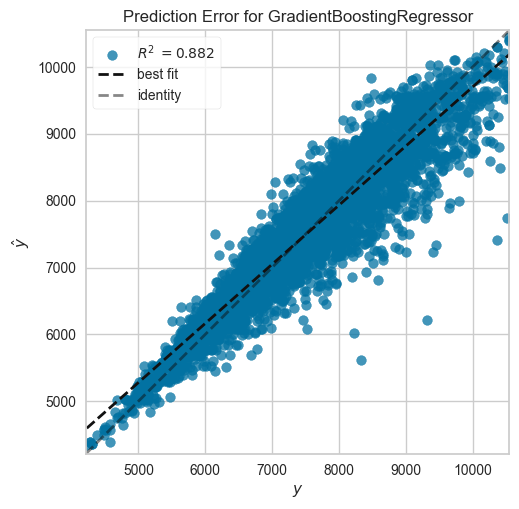

In [105]:
plot_model(final_model, plot='error')

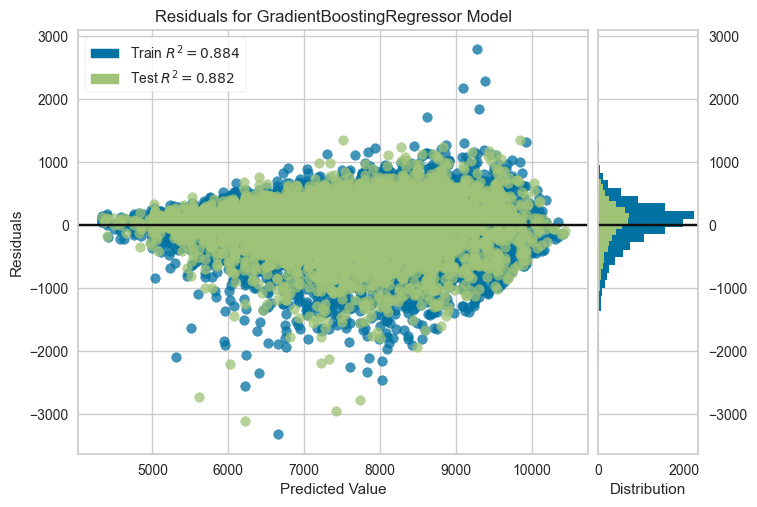

In [106]:
plot_model(final_model, plot='residuals')

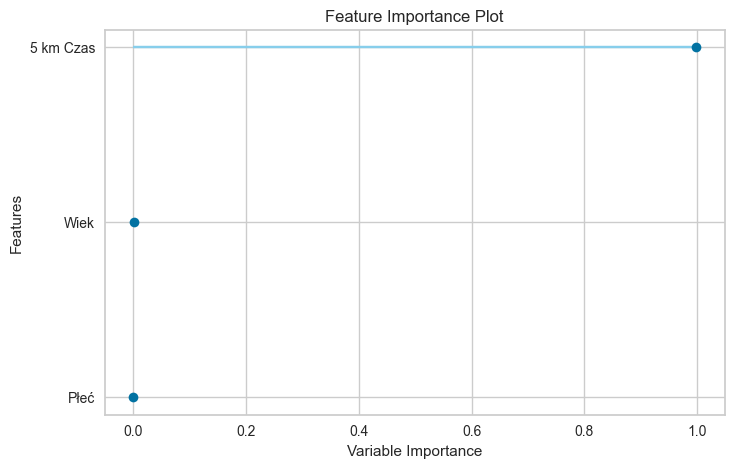

In [107]:
plot_model(final_model, plot='feature')

In [108]:
# Zapisujemy model do pliku maraton_pipeline.pkl
final_model = finalize_model(tuned_model)
save_model(final_model, 'models/maraton_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Wiek', '5 km Czas'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=OrdinalEncoder(cols=['Płeć'],
                                                                handle_missing='return_nan',
                                                                mapping=[{'col': 'Płeć',
                                                                          'data_type': dtype('float64'),
                                                                          'mapping': 0.0    0
 1.0    1
 NaN   -1
 dtype: int64}]))),
    

In [67]:
# dane_do_predykcji = pd.DataFrame({
#     'Wiek': [10],             # Wiek biegacza (np. 35 lat)
#     '5 km Czas': [60*36],      # Czas na 5 km w sekundach (np. 25 minut = 1500 sekund)
#     'Płeć': [1]               # 0 dla mężczyzny lub 1 dla kobiety
# })

In [68]:
# loaded_model = load_model('maraton_pipeline')
# prediction = predict_model(loaded_model, data=dane_do_predykcji)

Transformation Pipeline and Model Successfully Loaded


In [69]:
# time_in_seconds = prediction['prediction_label'][0]
# time_in_seconds = int(time_in_seconds)
# predicted_time = seconds_to_time(time_in_seconds)

# print(f"Przewidywany czas ukończenia: {predicted_time}")

Przewidywany czas ukończenia: 02:40:03


In [110]:
# zapisz model do Digital Ocean w folderze models
s3.upload_file(
    'models/maraton_pipeline.pkl',
    Bucket=BUCKET_NAME,
    Key='models/maraton_pipeline.pkl'
)

